In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

#import ray
#ray.init(include_dashboard=True, num_cpus = 8, dashboard_host='0.0.0.0')

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

plt.style.use('ggplot')

# UTILITY FUNCTIONS

In [2]:
subsampleFreq = 64   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

In [3]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY ARRAYS

In [4]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model1.pth'

npzfile = np.load(arraySavePath)
x_trainRTheta = npzfile['x_trainRTheta']
x_validRTheta = npzfile['x_validRTheta'] 
y_trainRTheta = npzfile['y_trainRTheta'] 
y_validRTheta = npzfile['y_validRTheta']

_,nY = y_validRTheta.shape

In [5]:
batch_size = 64

trainXTensor = torch.Tensor(x_trainRTheta)
trainYTensor = torch.Tensor(y_trainRTheta)

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validXTensor = torch.Tensor(x_validRTheta)
validYTensor = torch.Tensor(y_validRTheta)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([64, 5742])
Shape of y: torch.Size([64, 66]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([64, 5742])
Shape of y: torch.Size([64, 66]) torch.float32


In [6]:
loadFlag = True

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5742, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 66)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
if loadFlag == True:
    model.load_state_dict(torch.load("model.pth"))
    
model = model.to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5742, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=66, bias=True)
  )
)


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 50
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainDataLoader, model, loss_fn, optimizer)
    test(validDataLoader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.578027  [   64/89440]
loss: 1.589947  [ 6464/89440]
loss: 1.672600  [12864/89440]
loss: 1.567114  [19264/89440]
loss: 1.649360  [25664/89440]
loss: 1.614412  [32064/89440]
loss: 1.845916  [38464/89440]
loss: 1.655320  [44864/89440]
loss: 1.667727  [51264/89440]
loss: 1.771230  [57664/89440]
loss: 1.604250  [64064/89440]
loss: 1.673827  [70464/89440]
loss: 1.613971  [76864/89440]
loss: 1.865375  [83264/89440]
Test Error: 
 Avg loss: 2.191073 

Epoch 2
-------------------------------
loss: 1.723980  [   64/89440]
loss: 1.688337  [ 6464/89440]
loss: 1.733147  [12864/89440]
loss: 1.599796  [19264/89440]
loss: 1.507262  [25664/89440]
loss: 1.667760  [32064/89440]
loss: 1.571856  [38464/89440]
loss: 1.562245  [44864/89440]
loss: 1.611709  [51264/89440]
loss: 1.565585  [57664/89440]
loss: 1.726693  [64064/89440]
loss: 1.696476  [70464/89440]
loss: 1.502822  [76864/89440]
loss: 1.688461  [83264/89440]
Test Error: 
 Avg loss: 2.225672 

Epoch 3
--

In [45]:
torch.save(model.state_dict(), modelPath)

# Plot results of fit

<IPython.core.display.Javascript object>


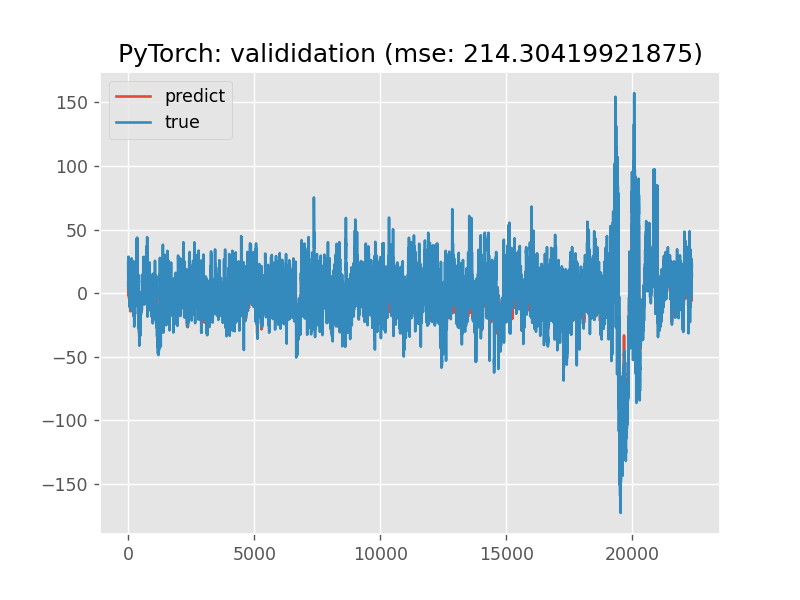

In [42]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
    
if trainPlotFlag:
    x = trainXTensor
    y = y_trainRTheta
    trainTitle = 'train'
else:
    x = validXTensor
    y = y_validRTheta
    trainTitle = 'valididation'
    

x = validXTensor.to(device)
freqPredict = model(x).cpu().detach().numpy()

_, yPred = realSTFTtoTimeSeries(freqPredict)
_, yTrue = realSTFTtoTimeSeries(y)

title = 'PyTorch: ' + trainTitle + ' (mse: %s)' % str(loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item())
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()